# 线性回归的从零开始实现
:label:`sec_linear_scratch`

在了解线性回归的关键思想之后，我们可以开始通过代码来动手实现线性回归了。
在这一节中，(**我们将从零开始实现整个方法，包括数据流水线、模型、损失函数和小批量随机梯度下降优化器**)。
虽然现代的深度学习框架几乎可以自动化地进行所有这些工作，但从零开始实现可以确保你真正知道自己在做什么。
同时，了解更细致的工作原理将方便我们自定义模型、自定义层或自定义损失函数。
在这一节中，我们将只使用张量和自动求导。在之后的章节中，我们会充分利用深度学习框架的优势，介绍更简洁的实现方式。


In [ ]:
pip install -U d2l

In [ ]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l


## 生成数据集

为了简单起见，我们将[**根据带有噪声的线性模型构造一个人造数据集。**]
我们的任务是使用这个有限样本的数据集来恢复这个模型的参数。
我们将使用低维数据，这样可以很容易地将其可视化。
在下面的代码中，我们生成一个包含1000个样本的数据集，每个样本包含从标准正态分布中采样的2个特征。我们的合成数据集是一个矩阵 $\mathbf{X}\in \mathbb{R}^{1000 \times 2}$。

(**我们使用线性模型参数$\mathbf{w} = [2, -3.4]^\top$、$b = 4.2$和噪声项$\epsilon$生成数据集及其标签：

$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.$$
**)

你可以将 $\epsilon$ 视为捕获特征和标签时的潜在观测误差。在这里我们认为标准假设成立，即$\epsilon$服从均值为0的正态分布。
为了简化问题，我们将标准差设为0.01。下面的代码生成合成数据集。


In [ ]:
def synthetic_data(w, b, num_examples):  #@save
    """生成 y = Xw + b + 噪声。"""
    X = torch.normal(0, 1, (num_examples, len(w))) #mean,std,size
    print("X.shape:",X.shape)#torch.Size([1000, 2])
    y = torch.matmul(X, w) + b#matmul两个张量的矩阵乘积
    print("y.shape:",y.shape)#torch.Size([1000])
    y += torch.normal(0, 0.01, y.shape)#0，0.01  平均数，标准偏差。  
                                       #返回从单独抽取随机数的张量正常分布
    print("y2.shape:",y.shape)#torch.Size([1000])
    return X, y.reshape((-1, 1))

In [ ]:
true_w = torch.tensor([2, -3.4])
print("true_w:",true_w)#tensor([ 2.0000, -3.4000])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print("features: {0},labels: {1} ".format(features.shape, labels.shape))
#features: torch.Size([1000, 2]),labels: torch.Size([1000, 1]) 

true_w: tensor([ 2.0000, -3.4000])
X.shape: torch.Size([1000, 2])
y.shape: torch.Size([1000])
y2.shape: torch.Size([1000])
features: torch.Size([1000, 2]),labels: torch.Size([1000, 1]) 


注意，[**`features` 中的每一行都包含一个二维数据样本，`labels` 中的每一行都包含一维标签值（一个标量）**]。


In [ ]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([-2.0263, -0.0583]) 
label: tensor([0.3452])


通过生成第二个特征 `features[:, 1]` 和 `labels` 的散点图，可以直观地观察到两者之间的线性关系。


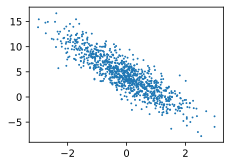

In [ ]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(),
                labels.detach().numpy(), 1);

## 读取数据集

回想一下，训练模型时要对数据集进行遍历，每次抽取一小批量样本，并使用它们来更新我们的模型。
由于这个过程是训练机器学习算法的基础，所以有必要定义一个函数，该函数能打乱数据集中的样本并以小批量方式获取数据。

在下面的代码中，我们[**定义一个`data_iter` 函数，
该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为`batch_size`的小批量**]。每个小批量包含一组特征和标签。


In [ ]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i +
                                                   batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
        #yield就是 return 返回一个值，并且记住这个返回的位置，下次迭代就从这个位置后开始。

通常，我们使用合理大小的小批量来利用GPU硬件的优势，因为GPU在并行处理方面表现出色。每个样本都可以并行地进行模型计算，且每个样本损失函数的梯度也可以被并行地计算，GPU可以在处理几百个样本时，所花费的时间不比处理一个样本时多太多。

让我们直观感受一下。读取第一个小批量数据样本并打印。每个批量的特征维度说明了批量大小和输入特征数。
同样的，批量的标签形状与 `batch_size` 相等。


In [ ]:
batch_size = 100

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.6879,  0.1913],
        [ 0.9416, -0.9170],
        [ 0.1642,  0.9246],
        [-2.3364,  1.6207],
        [-0.9860, -1.4719],
        [-2.5412, -0.1408],
        [-2.1901, -0.7958],
        [ 0.5518,  0.2916],
        [ 1.7908, -0.6184],
        [ 1.1940, -2.2780],
        [-1.8890,  0.1859],
        [-0.5170,  1.3014],
        [-0.7542, -0.4776],
        [-1.6694,  0.7742],
        [-0.4783,  0.5937],
        [ 1.5550, -0.7857],
        [-1.3238, -1.1496],
        [-0.5320, -0.1836],
        [-1.3634,  1.0239],
        [-0.4464, -0.5057],
        [ 1.3121, -2.3242],
        [ 0.4145,  1.5803],
        [ 0.8818, -0.6734],
        [ 1.1877,  0.2489],
        [ 1.0366, -0.0373],
        [-1.6135,  0.2063],
        [-0.5865, -1.6755],
        [ 1.9164, -0.8166],
        [ 1.1456, -1.3489],
        [ 0.7095, -0.2884],
        [-0.5323,  2.3290],
        [ 0.0216, -0.2646],
        [-0.7642,  1.9498],
        [ 1.9623,  1.1009],
        [-1.6386, -1.1407],
        [-2.0078, -0

当我们运行迭代时，我们会连续地获得不同的小批量，直至遍历完整个数据集。
上面实现的迭代对于教学来说很好，但它的执行效率很低，可能会在实际问题上陷入麻烦。
例如，它要求我们将所有数据加载到内存中，并执行大量的随机内存访问。
在深度学习框架中实现的内置迭代器效率要高得多，它可以处理存储在文件中的数据和通过数据流提供的数据。

[~~定义~~]
## (**初始化模型参数**)

在我们开始用小批量随机梯度下降优化我们的模型参数之前，我们需要先有一些参数。
在下面的代码中，我们通过从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重，并将偏置初始化为0。


In [ ]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

在初始化参数之后，我们的任务是更新这些参数，直到这些参数足够拟合我们的数据。
每次更新都需要计算损失函数关于模型参数的梯度。有了这个梯度，我们就可以向减小损失的方向更新每个参数。
因为手动计算梯度很枯燥而且容易出错，所以没有人会手动计算梯度。我们使用 :numref:`sec_autograd` 中引入的自动微分来计算梯度。

## (**定义模型**)

接下来，我们必须定义模型，将模型的输入和参数同模型的输出关联起来。
回想一下，要计算线性模型的输出，我们只需计算输入特征 $\mathbf{X}$ 和模型权重$\mathbf{w}$的矩阵-向量乘法后加上偏置$b$。注意，上面的$\mathbf{Xw}$ 是一个向量，而$b$是一个标量。回想一下 :numref:`subsec_broadcasting` 中描述的广播机制。当我们用一个向量加一个标量时，标量会被加到向量的每个分量上。


In [ ]:
def linreg(X, w, b):  #@save
    """线性回归模型。"""
    return torch.matmul(X, w) + b

## [**定义损失函数**]

因为要更新模型。需要计算损失函数的梯度，所以我们应该先定义损失函数。
这里我们使用 :numref:`sec_linear_regression` 中描述的平方损失函数。
在实现中，我们需要将真实值`y`的形状转换为和预测值`y_hat`的形状相同。


In [ ]:
def squared_loss(y_hat, y):  #@save
    """均方损失。"""
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

## (**定义优化算法**)

正如我们在 :numref:`sec_linear_regression` 中讨论的，线性回归有解析解。然而，这是一本关于深度学习的书，而不是一本关于线性回归的书。
由于这本书介绍的其他模型都没有解析解，下面我们将在这里介绍小批量随机梯度下降的工作示例。

在每一步中，使用从数据集中随机抽取的一个小批量，然后根据参数计算损失的梯度。接下来，朝着减少损失的方向更新我们的参数。
下面的函数实现小批量随机梯度下降更新。该函数接受模型参数集合、学习速率和批量大小作为输入。每一步更新的大小由学习速率`lr`决定。
因为我们计算的损失是一个批量样本的总和，所以我们用批量大小（`batch_size`）来归一化步长，这样步长大小就不会取决于我们对批量大小的选择。


In [ ]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降。"""#随机体现在随机选取样本进行梯度下降。
    with torch.no_grad():#是一个上下文管理器，
               #被该语句 wrap 起来的部分将不会track 梯度。
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## 训练

现在我们已经准备好了模型训练所有需要的要素，可以实现主要的[**训练过程**]部分了。
理解这段代码至关重要，因为在整个深度学习的职业生涯中，你会一遍又一遍地看到几乎相同的训练过程。
在每次迭代中，我们读取一小批量训练样本，并通过我们的模型来获得一组预测。
计算完损失后，我们开始反向传播，存储每个参数的梯度。最后，我们调用优化算法 `sgd` 来更新模型参数。

概括一下，我们将执行以下循环：

* 初始化参数
* 重复，直到完成
    * 计算梯度 $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * 更新参数 $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

在每个*迭代周期*（epoch）中，我们使用 `data_iter` 函数遍历整个数据集，并将训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。这里的迭代周期个数`num_epochs`和学习率`lr`都是超参数，分别设为3和0.03。设置超参数很棘手，需要通过反复试验进行调整。
我们现在忽略这些细节，以后会在 :numref:`chap_optimization` 中详细介绍。


In [ ]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [ ]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # `X`和`y`的小批量损失
        # 因为`l`形状是(`batch_size`, 1)，而不是一个标量。`l`中的所有元素被加到一起，
        # 并以此计算关于[`w`, `b`]的梯度
        
        l.sum().backward()#对loss进行反向传播
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():#禁用梯度计算的上下文管理器。
               #当您确定不会调用Tensor.backward(). 
               #它将减少原本需要 requires_grad=True 的计算的内存消耗。
        train_l = loss(net(features, w, b), labels)
        #print("train_l:", train_l)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.000050


因为我们使用的是自己合成的数据集，所以我们知道真正的参数是什么。
因此，我们可以通过[**比较真实参数和通过训练学到的参数来评估训练的成功程度**]。事实上，真实参数和通过训练学到的参数确实非常接近。


In [ ]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-4.3631e-05,  2.1458e-04], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0003], grad_fn=<RsubBackward1>)


注意，我们不应该想当然地认为我们能够完美地恢复参数。
在机器学习中，我们通常不太关心恢复真正的参数，而更关心那些能高度准确预测的参数。
幸运的是，即使是在复杂的优化问题上，随机梯度下降通常也能找到非常好的解。其中一个原因是，在深度网络中存在许多参数组合能够实现高度精确的预测。

## 小结

* 我们学习了深度网络是如何实现和优化的。在这一过程中只使用张量和自动微分，不需要定义层或复杂的优化器。
* 这一节只触及到了表面知识。在下面的部分中，我们将基于刚刚介绍的概念描述其他模型，并学习如何更简洁地实现其他模型。

## 练习

1. 如果我们将权重初始化为零，会发生什么。算法仍然有效吗？
1. 假设你是 [乔治·西蒙·欧姆](https://en.wikipedia.org/wiki/Georg_Ohm) ，试图为电压和电流的关系建立一个模型。你能使用自动微分来学习模型的参数吗?
1. 您能基于 [普朗克定律](https://en.wikipedia.org/wiki/Planck%27s_law) 使用光谱能量密度来确定物体的温度吗？
1. 如果你想计算二阶导数可能会遇到什么问题？你会如何解决这些问题？
1. 为什么在 `squared_loss` 函数中需要使用 `reshape` 函数？
1. 尝试使用不同的学习率，观察损失函数值下降的快慢。
1. 如果样本个数不能被批量大小整除，`data_iter`函数的行为会有什么变化？


[Discussions](https://discuss.d2l.ai/t/1778)
